# Adaptive Regime Strategy

## v1

Fetching data for AAPL with 2 years of warm-up history...
Engineering Features (FracDiff, Yang-Zhang)...
Detecting Market Regimes (Unsupervised Learning w/ Walk-Forward)...
Training GMM with Expanding Window (Start: 252 days, Step: 20 days)...
Signals Generated.

--- Institutional Performance Report: AAPL ---
Total Return:   37.26%
Sharpe Ratio:   0.91  (>1.0 is Good)
Sortino Ratio:  1.07  (>1.5 is Excellent)
Max Drawdown:   -17.56% (Pain Threshold)
Calmar Ratio:   2.12
---------------------------------------------------

Plotting polished results... (Close window to finish)


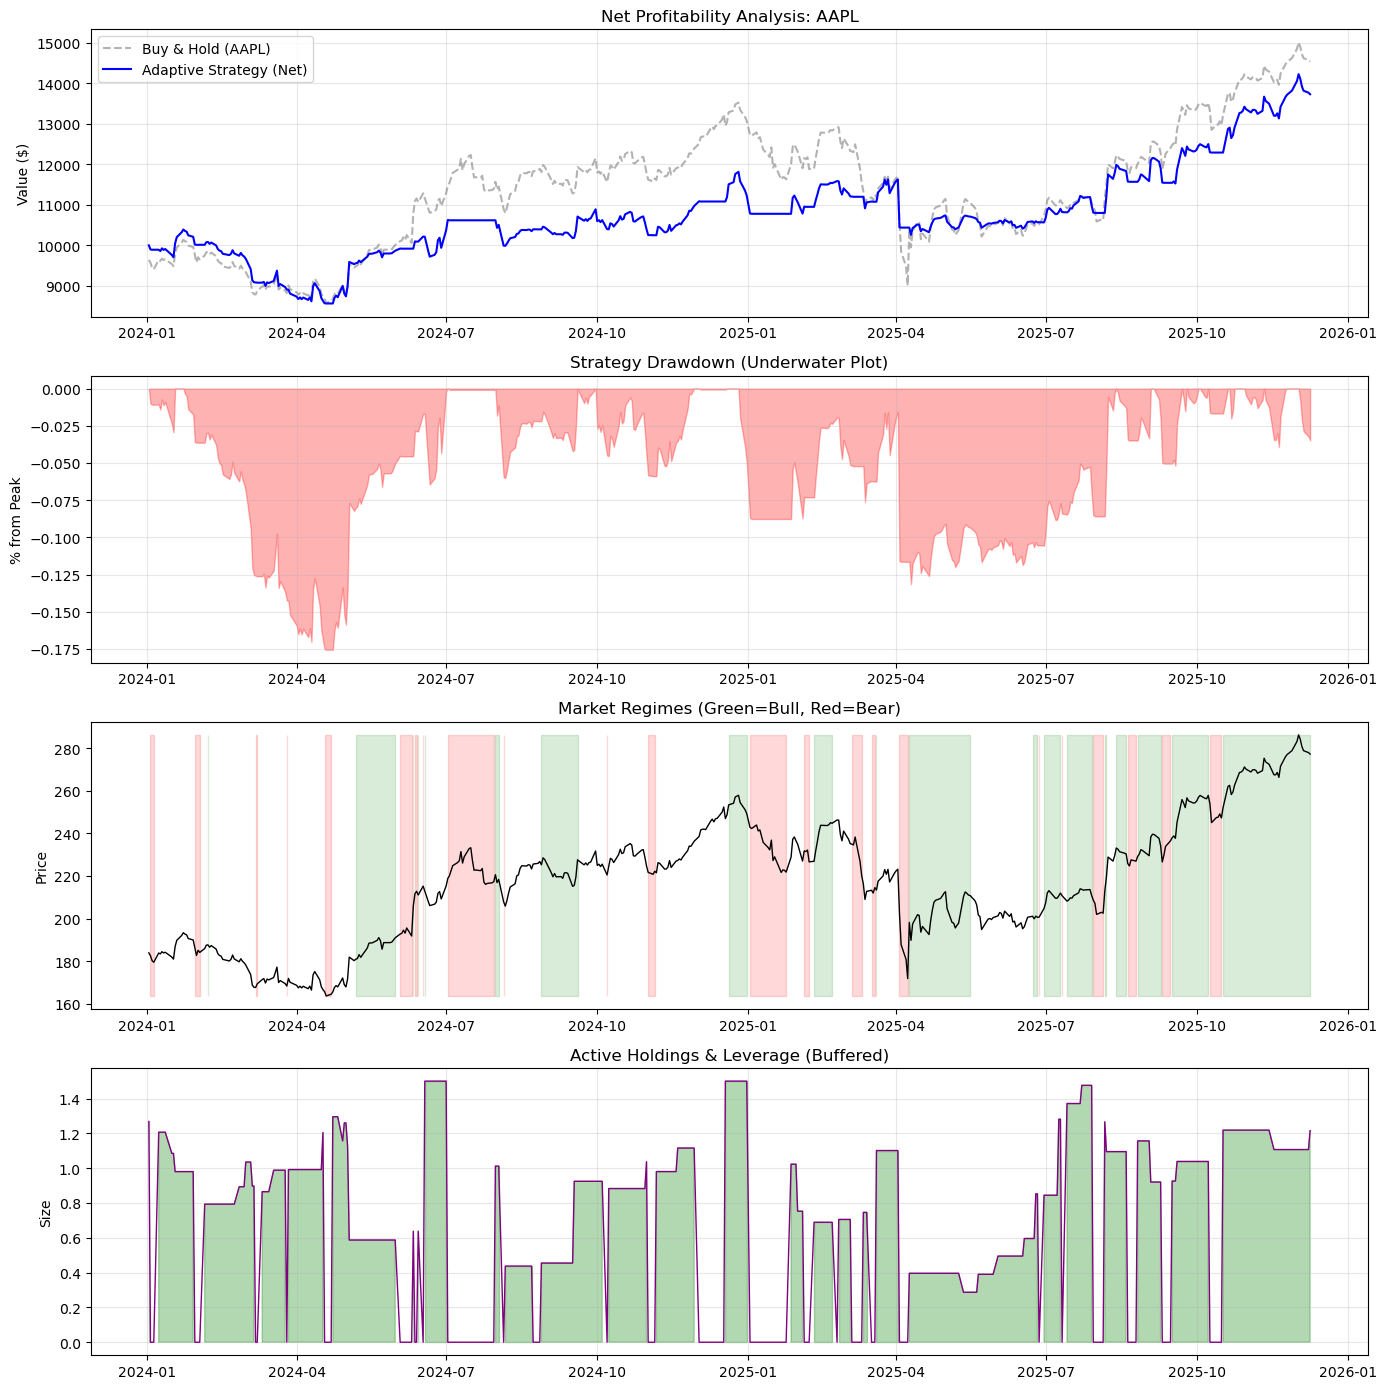

In [42]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from abc import ABC, abstractmethod
import warnings
from datetime import datetime, timedelta

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# ==========================================
# 1. ADVANCED FEATURE ENGINEERING (Math Lab)
# ==========================================

class FeatureLab:
    """
    Implements advanced signal processing techniques described in the MIT research plan.
    Includes Fractional Differentiation and Yang-Zhang Volatility.
    """

    @staticmethod
    def get_weights_frac_diff(d, size, threshold=1e-5):
        """
        Calculates weights for fractional differentiation using the binomial expansion.
        Ref: Section 2.1.1 of Research Plan.
        """
        w = [1.0]
        for k in range(1, size):
            w_k = -w[-1] / k * (d - k + 1)
            w.append(w_k)
        
        w = np.array(w[::-1])
        w = w[np.abs(w) > threshold]
        return w

    @staticmethod
    def frac_diff_fixed(series, d, window=50):
        """
        Applies fractional differentiation to a pandas Series.
        Preserves memory while achieving stationarity.
        """
        weights = FeatureLab.get_weights_frac_diff(d, window)
        # Apply dot product over rolling window
        res = series.rolling(window=len(weights)).apply(lambda x: np.dot(x, weights), raw=True)
        return res

    @staticmethod
    def yang_zhang_volatility(df, window=30):
        """
        Computes Yang-Zhang Volatility: Minimum variance, unbiased, drift-independent.
        Ref: Section 2.2 of Research Plan.
        """
        log_ho = (df['High'] / df['Open']).apply(np.log)
        log_lo = (df['Low'] / df['Open']).apply(np.log)
        log_co = (df['Close'] / df['Open']).apply(np.log)
        
        log_oc = (df['Open'] / df['Close'].shift(1)).apply(np.log)
        log_cc = (df['Close'] / df['Close'].shift(1)).apply(np.log)
        
        rs = log_ho * (log_ho - log_co) + log_lo * (log_lo - log_co)
        
        close_vol = log_cc.rolling(window=window).var()
        open_vol = log_oc.rolling(window=window).var()
        window_rs = rs.rolling(window=window).mean()

        k = 0.34 / (1.34 + (window + 1) / (window - 1))
        
        yz_vol = np.sqrt(open_vol + k * window_rs)
        return yz_vol

    @staticmethod
    def compute_relative_strength(series, window=14):
        """Standard RSI for Mean Reversion components."""
        delta = series.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
        rs = gain / loss
        return 100 - (100 / (1 + rs))

# ==========================================
# 2. MARKET REGIME DETECTION (Behavioral Lab)
# ==========================================

class RegimeIdentifier:
    """
    Uses Unsupervised Learning (GMM) to decode latent market states.
    Ref: Section 3.1 & 3.2 of Research Plan.
    """
    def __init__(self, n_components=3):
        # 3 components: 0=Bear/HighVol, 1=Sideways, 2=Bull/LowVol
        self.n_components = n_components
        self.is_fitted = False

    def fit_predict(self, df, min_window=252, step=20):
        """
        Fits GMM on an EXPANDING WINDOW to prevent look-ahead bias.
        """
        data = df.copy().dropna()
        
        # Use Rolling Mean of Returns to classify "Trend" not "Noise"
        data['Returns_Smoothed'] = data['Returns'].rolling(window=5).mean()
        data['Volatility_Smoothed'] = data['Volatility'].rolling(window=5).mean()
        data.dropna(inplace=True)

        data['Regime_Label'] = np.nan
        
        if len(data) <= min_window:
            print(f"Warning: Not enough data (Need > {min_window}, got {len(data)})")
            return data

        print(f"Training GMM with Expanding Window (Start: {min_window} days, Step: {step} days)...")
        
        predictions = []
        indices = []
        
        # Iterate through time
        for t in range(min_window, len(data), step):
            train_df = data.iloc[:t]
            test_df = data.iloc[t : t + step]
            
            if test_df.empty:
                break
                
            X_train = train_df[['Returns_Smoothed', 'Volatility_Smoothed']].values
            X_test = test_df[['Returns_Smoothed', 'Volatility_Smoothed']].values
            
            # 1. Fit Scaler on TRAIN only
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            # 2. Fit GMM on TRAIN
            model = GaussianMixture(n_components=self.n_components, covariance_type="full", random_state=42)
            model.fit(X_train_scaled)
            
            # 3. Predict on TEST
            pred_labels = model.predict(X_test_scaled)
            
            # 4. DYNAMIC MAPPING (Map Clusters to Semantic Meaning)
            train_labels = model.predict(X_train_scaled)
            temp_train = train_df.copy()
            temp_train['Cluster'] = train_labels
            
            # Sort clusters by Mean Return
            cluster_stats = temp_train.groupby('Cluster')['Returns_Smoothed'].mean()
            sorted_clusters = cluster_stats.sort_values().index
            
            mapping = {
                sorted_clusters[0]: -1, # Bear
                sorted_clusters[1]: 0,  # Sideways
                sorted_clusters[2]: 1   # Bull
            }
            
            mapped_preds = [mapping[label] for label in pred_labels]
            predictions.extend(mapped_preds)
            indices.extend(test_df.index)

        # Assign predictions
        pred_series = pd.Series(predictions, index=indices)
        data.loc[pred_series.index, 'Regime_Label'] = pred_series
        
        # Drop warm-up NaN period
        data.dropna(subset=['Regime_Label'], inplace=True)
        
        self.is_fitted = True
        return data

# ==========================================
# 3. STRATEGY ABSTRACTION
# ==========================================

class Strategy(ABC):
    """Abstract Base Class for all trading strategies."""
    
    def __init__(self, ticker, start_date, end_date):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.data = None
        self.results = None

    def fetch_data(self, warmup_years=2):
        """
        Fetches data with an automatic warm-up period.
        
        Args:
            warmup_years (int): Number of extra years of history to fetch before start_date.
                                This ensures indicators (GMM, FracDiff) are stable by start_date.
        """
        print(f"Fetching data for {self.ticker} with {warmup_years} years of warm-up history...")
        
        # Calculate fetch start date (Start Date - Warmup Years)
        start_dt = datetime.strptime(self.start_date, "%Y-%m-%d")
        warmup_start_dt = start_dt - timedelta(days=warmup_years*365)
        warmup_start_str = warmup_start_dt.strftime("%Y-%m-%d")
        
        try:
            self.data = yf.download(self.ticker, start=warmup_start_str, end=self.end_date, progress=False, auto_adjust=False)
        except Exception as e:
            print(f"Warning: Download failed: {e}")
            return

        if isinstance(self.data.columns, pd.MultiIndex):
            self.data.columns = self.data.columns.get_level_values(0)

        if 'Adj Close' not in self.data.columns:
            if 'Close' in self.data.columns:
                print("Note: Using 'Close' as fallback for 'Adj Close'.")
                self.data['Adj Close'] = self.data['Close']
            else:
                raise KeyError(f"Price columns missing for {self.ticker}.")

        self.data['Returns'] = self.data['Adj Close'].pct_change()
        self.data.dropna(inplace=True)

    @abstractmethod
    def generate_signals(self):
        pass

    def run_backtest(self, initial_capital=10000, transaction_cost=0.0005, rebalance_threshold=0.1):
        """
        Vectorized Backtest Engine with Transaction Costs and Trade Buffering.
        
        Args:
            transaction_cost (float): Cost per trade (e.g., 0.0005 = 5bps = 0.05%)
            rebalance_threshold (float): Minimum change in position size required to trigger a trade.
                                         (e.g., 0.1 means position must change by 10%).
        """
        if 'Signal' not in self.data.columns:
            raise ValueError("Signals not generated yet.")
        
        # 1. Slice Data: Discard Warm-up period for the Backtest Analysis
        # We only want to test from the user's requested START date
        backtest_mask = self.data.index >= self.start_date
        # Note: We need one row prior to start_date for shift logic, but simple slicing is safer 
        # given the regime detection is already done.
        df = self.data.loc[backtest_mask].copy()
        
        if df.empty:
            raise ValueError(f"No data found starting from {self.start_date}. Check date ranges.")

        # 2. Apply Trade Buffering (Hysteresis)
        # Iterate to apply rebalance logic: Only trade if abs(New - Old) > Threshold
        clean_positions = []
        current_pos = 0.0
        
        # Pre-convert to numpy for speed
        raw_signals = df['Signal'].values
        
        for target in raw_signals:
            if abs(target - current_pos) > rebalance_threshold:
                current_pos = target
            clean_positions.append(current_pos)
            
        df['Position'] = clean_positions
        
        # 3. Calculate Returns
        # Shift Position by 1 to simulate trading at NEXT Open/Close based on Today's decision
        df['Prev_Position'] = df['Position'].shift(1)
        df['Prev_Position'].fillna(0, inplace=True)
        
        # Calculate Turnover (Change in held position)
        df['Turnover'] = (df['Prev_Position'] - df['Position'].shift(2).fillna(0)).abs()
        
        # Gross Returns (Strategy Return = Prev_Position * Day_Return)
        df['Gross_Returns'] = df['Prev_Position'] * df['Returns']
        
        # Net Returns (Subtract transaction costs)
        df['Net_Returns'] = df['Gross_Returns'] - (df['Turnover'] * transaction_cost)
        
        # Fill NaNs
        df['Net_Returns'].fillna(0, inplace=True)
        df['Returns'].fillna(0, inplace=True)
        
        # Cumulative
        df['Cumulative_Market'] = (1 + df['Returns']).cumprod() * initial_capital
        df['Cumulative_Strategy'] = (1 + df['Net_Returns']).cumprod() * initial_capital
        
        # Track Drawdown for Strategy
        roll_max = df['Cumulative_Strategy'].cummax()
        df['Drawdown'] = (df['Cumulative_Strategy'] / roll_max) - 1.0
        
        self.results = df
        return df

    def performance_metrics(self):
        df = self.results
        
        # 1. Total Return
        total_return = (df['Cumulative_Strategy'].iloc[-1] / df['Cumulative_Strategy'].iloc[0]) - 1
        
        # 2. Sharpe Ratio (Annualized)
        daily_excess = df['Net_Returns']
        sharpe = (daily_excess.mean() / daily_excess.std()) * np.sqrt(252)
        
        # 3. Max Drawdown
        max_drawdown = df['Drawdown'].min()
        
        # 4. Sortino Ratio (Downside Deviation only)
        negative_returns = daily_excess[daily_excess < 0]
        downside_std = negative_returns.std()
        sortino = (daily_excess.mean() / downside_std) * np.sqrt(252) if downside_std != 0 else np.nan
        
        # 5. Calmar Ratio
        calmar = (total_return / abs(max_drawdown)) if max_drawdown != 0 else np.nan

        print(f"\n--- Institutional Performance Report: {self.ticker} ---")
        print(f"Total Return:   {total_return:.2%}")
        print(f"Sharpe Ratio:   {sharpe:.2f}  (>1.0 is Good)")
        print(f"Sortino Ratio:  {sortino:.2f}  (>1.5 is Excellent)")
        print(f"Max Drawdown:   {max_drawdown:.2%} (Pain Threshold)")
        print(f"Calmar Ratio:   {calmar:.2f}")
        print("---------------------------------------------------")
        
        return total_return, sharpe

# ==========================================
# 4. CONCRETE STRATEGY: ADAPTIVE REGIME
# ==========================================

class AdaptiveRegimeStrategy(Strategy):
    """
    Implements the core thesis: Different regimes require different logic.
    Ref: Section 1.1 & 3.3 of Research Plan.
    """

    def generate_signals(self):
        print("Engineering Features (FracDiff, Yang-Zhang)...")
        
        self.data['Volatility'] = FeatureLab.yang_zhang_volatility(self.data)
        # Use window=50 for stable long-term memory
        self.data['FracDiff'] = FeatureLab.frac_diff_fixed(self.data['Adj Close'].apply(np.log), d=0.4, window=50)
        self.data['RSI'] = FeatureLab.compute_relative_strength(self.data['Adj Close'])
        
        self.data.dropna(inplace=True)
        
        # Detect Regimes (Expanding Window)
        print("Detecting Market Regimes (Unsupervised Learning w/ Walk-Forward)...")
        regime_engine = RegimeIdentifier()
        self.data = regime_engine.fit_predict(self.data, min_window=252, step=20)
        
        # Logic Application
        self.data['Signal'] = 0
        
        # BULL (1): Trend Following
        bull_condition = (self.data['Regime_Label'] == 1) & (self.data['FracDiff'] > 0)
        self.data.loc[bull_condition, 'Signal'] = 1
        
        # SIDEWAYS (0): Mean Reversion (Dip Buy)
        sideways_long = (self.data['Regime_Label'] == 0) & (self.data['RSI'] < 40)
        self.data.loc[sideways_long, 'Signal'] = 1
        
        # BEAR (-1): Cash
        bear_condition = (self.data['Regime_Label'] == -1)
        self.data.loc[bear_condition, 'Signal'] = 0 
        
        # MOMENTUM OVERRIDE (Stay long in strong trends even if RSI is high, unless extreme)
        strong_trend_override = (self.data['Regime_Label'] == 0) & \
                                (self.data['FracDiff'] > 1e-4) & \
                                (self.data['RSI'] > 40) & \
                                (self.data['RSI'] < 80)
        self.data.loc[strong_trend_override, 'Signal'] = 1

        # Volatility Targeting (Risk Management)
        # Target 15% Annualized Volatility
        target_vol = 0.15 / np.sqrt(252)
        self.data['Vol_Scaler'] = target_vol / self.data['Volatility']
        self.data['Vol_Scaler'] = self.data['Vol_Scaler'].clip(upper=1.5) 
        
        self.data['Signal'] = self.data['Signal'] * self.data['Vol_Scaler']

        print("Signals Generated.")

    def plot_results(self):
        plt.figure(figsize=(14, 14))
        
        # Subplot 1: Equity Curve
        ax1 = plt.subplot(4, 1, 1)
        ax1.plot(self.results['Cumulative_Market'], label=f'Buy & Hold ({self.ticker})', color='gray', alpha=0.6, linestyle='--')
        ax1.plot(self.results['Cumulative_Strategy'], label='Adaptive Strategy (Net)', color='blue', linewidth=1.5)
        ax1.set_title(f"Net Profitability Analysis: {self.ticker}")
        ax1.set_ylabel("Value ($)")
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Subplot 2: Drawdown (Underwater Plot)
        ax2 = plt.subplot(4, 1, 2, sharex=ax1)
        ax2.fill_between(self.results.index, self.results['Drawdown'], 0, color='red', alpha=0.3)
        ax2.set_title("Strategy Drawdown (Underwater Plot)")
        ax2.set_ylabel("% from Peak")
        ax2.grid(True, alpha=0.3)

        # Subplot 3: Regimes
        ax3 = plt.subplot(4, 1, 3, sharex=ax1)
        # Slice original data to match backtest range for plotting
        plot_data = self.data.loc[self.results.index]
        prices = plot_data['Adj Close']
        y_min, y_max = prices.min(), prices.max()
        
        bull_mask = plot_data['Regime_Label'] == 1
        bear_mask = plot_data['Regime_Label'] == -1
        
        ax3.plot(prices, color='black', linewidth=1, label='Price')
        ax3.fill_between(plot_data.index, y_min, y_max, where=bull_mask, color='green', alpha=0.15, label='Bull')
        ax3.fill_between(plot_data.index, y_min, y_max, where=bear_mask, color='red', alpha=0.15, label='Bear')
        ax3.set_title("Market Regimes (Green=Bull, Red=Bear)")
        ax3.set_ylabel("Price")
        
        # Subplot 4: Holdings
        ax4 = plt.subplot(4, 1, 4, sharex=ax1)
        # Use the 'Position' column from results which has the buffered trades
        signal = self.results['Position']
        ax4.plot(signal, color='purple', linewidth=1, label='Position Size')
        ax4.fill_between(signal.index, signal, 0, where=(signal > 0), color='green', alpha=0.3)
        ax4.set_title("Active Holdings & Leverage (Buffered)")
        ax4.set_ylabel("Size")
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# ==========================================
# 5. EXECUTION BLOCK
# ==========================================

if __name__ == "__main__":
    # Configuration
    TICKER = "AAPL"
    START = "2024-01-01" # Testing a longer period
    END = "2025-12-10"
    
    # Instantiate
    strategy = AdaptiveRegimeStrategy(TICKER, START, END)
    
    try:
        # Fetch with warm-up (e.g., fetch data starting 2013 for 2015 start)
        strategy.fetch_data(warmup_years=2)
        strategy.generate_signals()
        
        # Run Backtest with Transaction Costs and Trade Buffer
        # rebalance_threshold=0.1 means we only trade if size changes by >10%
        strategy.run_backtest(transaction_cost=0.0005, rebalance_threshold=0.1)
        
        strategy.performance_metrics()
        
        print("\nPlotting polished results... (Close window to finish)")
        strategy.plot_results()
        
    except Exception as e:
        print(f"An error occurred: {e}")

## v2

To take this system from a "strong research project" to an "institutional-grade strategy," you should focus on making the signals more stable and the features more diverse.

Here are four high-impact ways to improve the method:

### 1. Reduce "Regime Flickering" (Hysteresis)

As you saw in your diagrams, the model sometimes switches between Bull and Bear very rapidly. This creates high transaction costs.

* **The Fix:** Implement a "Stability Buffer." Instead of switching regimes as soon as the probability hits 51%, only switch if the new regime's probability is above 80%.
* **Benefit:** This keeps you in a position longer and prevents "death by a thousand cuts" from trading fees.

### 2. Diversify the "Sensors" (Multi-Asset and Macro)

Currently, the model only looks at the price of one stock (AAPL).

* **Cross-Asset Signals:** Add the volatility of the **VIX** (Fear Index) or the **10-Year Treasury Yield** as features in your GMM. Often, a spike in bond yields or market-wide fear precedes a crash in a specific stock.
* **Macro Integration:** As we discussed, adding monthly Inflation (CPI) or Business Confidence (PMI) data helps the model understand if a price drop is just "market noise" or a fundamental economic shift.

### 3. Optimization of "d" in Fractional Differentiation

In your code, the "d" value is fixed at **0.4**.

* **The Fix:** Use an **Augmented Dickey-Fuller (ADF) test** to find the *minimum* amount of differentiation needed to make the data stationary.
* **Why it matters:** If  is too high, you lose predictive memory. If it's too low, the data isn't stationary, and your GMM will produce "junk" results. Optimizing  ensures you keep the maximum amount of "memory" possible while keeping the math valid.

### 4. Advanced Risk Management (Conditional VaR)

Your current strategy uses "Volatility Targeting," which assumes market returns follow a normal bell curve.

* **The Fix:** Switch to **Expected Shortfall (CVaR)**. This measures the risk of "Tail Events" (extreme crashes) rather than just standard volatility.
* **Benefit:** This is much better at protecting you during "Black Swan" events where the standard volatility measure fails to capture the true danger.

---

### Summary Table of Improvements

| Improvement | Focus Area | Difficulty | Expected Impact |
| --- | --- | --- | --- |
| **Hysteresis Buffer** | Transaction Costs | Low | Higher Net Profit |
| **Macro Features** | Regime Accuracy | Medium | Better Bear Detection |
| **ADF Optimization** | Feature Engineering | Medium | More Reliable Signals |
| **CVaR Sizing** | Risk Management | High | Smaller Max Drawdowns |

**Would you like me to show you the Python code to implement the ADF test for finding the optimal "d" value?**

Fetching Data (Asset + Macro Sensors) with 2y warm-up...
1. Engineering Features...
Optimizing Fractional Differentiation (ADF Test)...
  -> Optimal d found: 0.25 (p-value: 0.0121)
2. Detecting Regimes (Multi-Asset + Hysteresis)...
Training Robust GMM (Features: ['Returns_Smoothed', 'Volatility_Smoothed', 'VIX_Smoothed'])...
Signals Generated.

--- Strategy v2.1 Performance: AAPL ---
Total Return:   44.75%
Sharpe Ratio:   0.99
Max Drawdown:   -27.74%

Plotting v2.2 results...


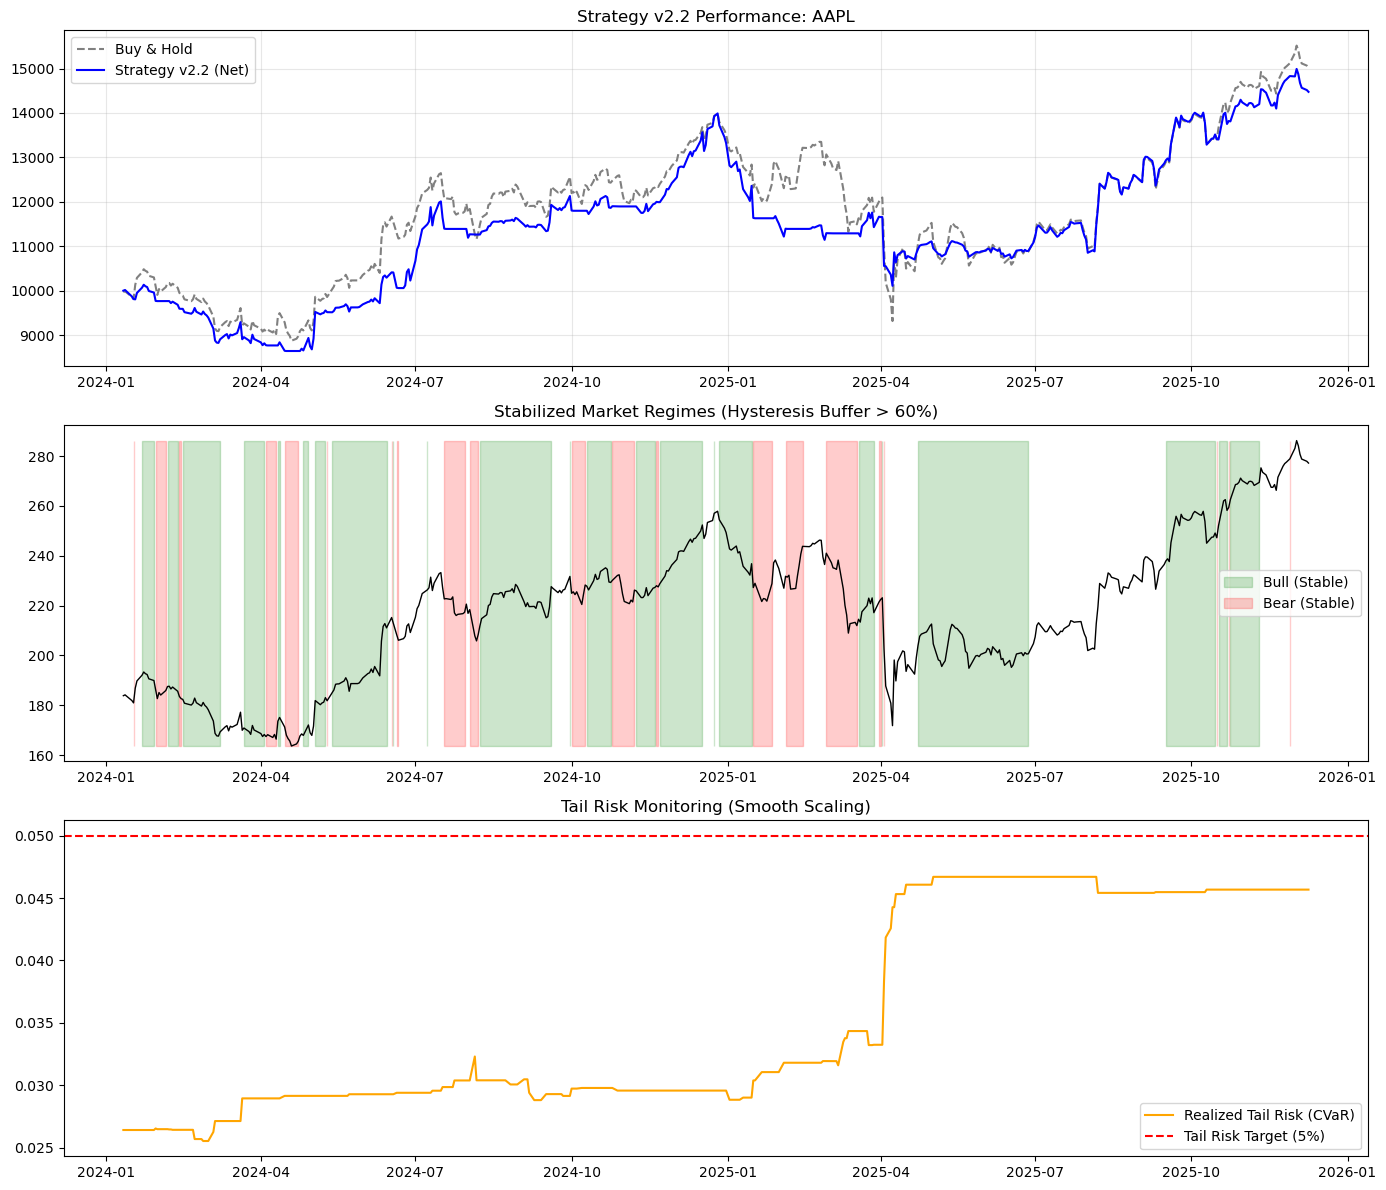

In [43]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from abc import ABC, abstractmethod
import warnings
from datetime import datetime, timedelta

# Suppress warnings
warnings.filterwarnings('ignore')

# ==========================================
# 1. ADVANCED FEATURE ENGINEERING (Math Lab)
# ==========================================

class FeatureLab:
    """
    Implements advanced signal processing techniques.
    Upgrades: 
    - Auto-Optimization of FracDiff 'd' parameter using ADF test.
    - CVaR (Expected Shortfall) calculation.
    """

    @staticmethod
    def get_weights_frac_diff(d, size, threshold=1e-5):
        w = [1.0]
        for k in range(1, size):
            w_k = -w[-1] / k * (d - k + 1)
            w.append(w_k)
        w = np.array(w[::-1])
        w = w[np.abs(w) > threshold]
        return w

    @staticmethod
    def frac_diff_fixed(series, d, window=50):
        weights = FeatureLab.get_weights_frac_diff(d, window)
        res = series.rolling(window=len(weights)).apply(lambda x: np.dot(x, weights), raw=True)
        return res

    @staticmethod
    def optimize_fractional_diff(series, window=50, max_d=1.0, step=0.05):
        """
        Iteratively finds the minimum 'd' required to pass the ADF Stationarity test.
        Preserves maximum memory (lowest d) while ensuring statistical validity.
        """
        print("Optimizing Fractional Differentiation (ADF Test)...")
        # Log prices are standard for FracDiff
        log_prices = series.apply(np.log).dropna()
        
        best_d = max_d
        
        # Search for minimum d
        for d in np.arange(0, max_d + step, step):
            # Apply diff
            diff_series = FeatureLab.frac_diff_fixed(log_prices, d, window).dropna()
            
            if len(diff_series) < 50:
                continue
                
            # Run ADF Test
            # Null Hypothesis: Series is Non-Stationary. 
            # If p_value < 0.05, we reject Null (Series IS Stationary).
            adf_result = adfuller(diff_series, maxlag=1, regression='c', autolag=None)
            p_value = adf_result[1]
            
            if p_value < 0.05:
                best_d = d
                print(f"  -> Optimal d found: {best_d:.2f} (p-value: {p_value:.4f})")
                return best_d, diff_series
        
        print(f"  -> Warning: Stationarity not achieved. Defaulting to d={max_d}")
        return max_d, FeatureLab.frac_diff_fixed(log_prices, max_d, window)

    @staticmethod
    def yang_zhang_volatility(df, window=30):
        log_ho = (df['High'] / df['Open']).apply(np.log)
        log_lo = (df['Low'] / df['Open']).apply(np.log)
        log_co = (df['Close'] / df['Open']).apply(np.log)
        
        log_oc = (df['Open'] / df['Close'].shift(1)).apply(np.log)
        log_cc = (df['Close'] / df['Close'].shift(1)).apply(np.log)
        
        rs = log_ho * (log_ho - log_co) + log_lo * (log_lo - log_co)
        
        close_vol = log_cc.rolling(window=window).var()
        open_vol = log_oc.rolling(window=window).var()
        window_rs = rs.rolling(window=window).mean()
        
        k = 0.34 / (1.34 + (window + 1) / (window - 1))
        return np.sqrt(open_vol + k * window_rs)

    @staticmethod
    def compute_cvar(returns, window=252, confidence=0.05):
        """
        Calculates Conditional Value at Risk (Expected Shortfall).
        Average of the worst 5% of returns in the window.
        """
        # We want the magnitude of loss, so we look at the lower tail
        rolling_cvar = returns.rolling(window=window).apply(
            lambda x: np.abs(x[x <= np.percentile(x, 100 * confidence)].mean()) 
            if len(x[x <= np.percentile(x, 100 * confidence)]) > 0 else 0.0,
            raw=True
        )
        return rolling_cvar

    @staticmethod
    def compute_rsi(series, window=14):
        delta = series.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
        rs = gain / loss
        return 100 - (100 / (1 + rs))

# ==========================================
# 2. ROBUST REGIME DETECTION (Hysteresis)
# ==========================================

class RegimeIdentifier:
    def __init__(self, n_components=3):
        self.n_components = n_components
        self.is_fitted = False

    def fit_predict_robust(self, df, external_data=None, min_window=252, step=20, prob_threshold=0.60):
        """
        Expanding Window GMM with:
        1. Multi-Asset Features (VIX, TNX)
        2. Hysteresis (Stability Buffer): Only switch if prob > threshold.
        
        Update: Lowered default threshold to 0.60 to reduce lag while maintaining stability.
        """
        data = df.copy().dropna()
        
        # 1. Feature Engineering for GMM
        data['Returns_Smoothed'] = data['Returns'].rolling(window=5).mean()
        data['Volatility_Smoothed'] = data['Volatility'].rolling(window=5).mean()
        
        # Add External Macro Data if available
        feature_cols = ['Returns_Smoothed', 'Volatility_Smoothed']
        if external_data is not None:
            # Join external data
            data = data.join(external_data, how='inner')
            # Use smoothed versions for GMM
            for col in external_data.columns:
                # IMPORTANT: External data must be stationary (Returns/Diffs), not raw levels
                data[f'{col}_Smoothed'] = data[col].rolling(window=5).mean()
                feature_cols.append(f'{col}_Smoothed')
        
        data.dropna(inplace=True)
        data['Regime_Label'] = np.nan
        
        if len(data) <= min_window:
            return data

        print(f"Training Robust GMM (Features: {feature_cols})...")
        
        predictions = []
        indices = []
        
        # Track the "Active Regime" for Hysteresis
        # Initialize with Neutral (0)
        current_regime_label = 0 
        
        for t in range(min_window, len(data), step):
            train_df = data.iloc[:t]
            test_df = data.iloc[t : t + step]
            
            if test_df.empty:
                break
                
            X_train = train_df[feature_cols].values
            X_test = test_df[feature_cols].values
            
            # Scale
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            # Fit GMM
            model = GaussianMixture(n_components=self.n_components, covariance_type="full", random_state=42)
            model.fit(X_train_scaled)
            
            # Dynamic Mapping (Cluster -> Semantic Label)
            train_labels = model.predict(X_train_scaled)
            temp_train = train_df.copy()
            temp_train['Cluster'] = train_labels
            
            # Sort clusters by Mean Return of the Asset
            cluster_stats = temp_train.groupby('Cluster')['Returns_Smoothed'].mean()
            sorted_clusters = cluster_stats.sort_values().index
            
            # Mapping: 0=Bear, 1=Sideways, 2=Bull (Indices of sorted_clusters)
            cluster_to_label = {
                sorted_clusters[0]: -1, # Bear
                sorted_clusters[1]: 0,  # Sideways
                sorted_clusters[2]: 1   # Bull
            }
            
            # Predict Probabilities for Test Chunk
            probs = model.predict_proba(X_test_scaled)
            
            # Apply Hysteresis per day in the test chunk
            chunk_preds = []
            for i in range(len(probs)):
                day_probs = probs[i] # [Prob_Cluster0, Prob_Cluster1, Prob_Cluster2]
                
                # Invert the mapping: Label -> Cluster
                label_to_cluster = {v: k for k, v in cluster_to_label.items()}
                
                prob_bear = day_probs[label_to_cluster[-1]]
                prob_sideways = day_probs[label_to_cluster[0]]
                prob_bull = day_probs[label_to_cluster[1]]
                
                mapped_probs = {-1: prob_bear, 0: prob_sideways, 1: prob_bull}
                best_candidate = max(mapped_probs, key=mapped_probs.get)
                
                # HYSTERESIS LOGIC:
                if best_candidate != current_regime_label:
                    if mapped_probs[best_candidate] > prob_threshold:
                        current_regime_label = best_candidate
                    # Else: Keep current_regime_label (Buffer)
                
                chunk_preds.append(current_regime_label)
            
            predictions.extend(chunk_preds)
            indices.extend(test_df.index)

        pred_series = pd.Series(predictions, index=indices)
        data.loc[pred_series.index, 'Regime_Label'] = pred_series
        data.dropna(subset=['Regime_Label'], inplace=True)
        
        self.is_fitted = True
        return data

# ==========================================
# 3. STRATEGY ABSTRACTION
# ==========================================

class Strategy(ABC):
    def __init__(self, ticker, start_date, end_date):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.data = None
        self.results = None
        # New Multi-Asset Containers
        self.vix = None
        self.tnx = None

    def fetch_data(self, warmup_years=3):
        print(f"Fetching Data (Asset + Macro Sensors) with {warmup_years}y warm-up...")
        
        start_dt = datetime.strptime(self.start_date, "%Y-%m-%d")
        warmup_start_dt = start_dt - timedelta(days=warmup_years*365)
        warmup_start_str = warmup_start_dt.strftime("%Y-%m-%d")
        
        # 1. Main Ticker
        self.data = yf.download(self.ticker, start=warmup_start_str, end=self.end_date, progress=False, auto_adjust=False)
        if isinstance(self.data.columns, pd.MultiIndex): self.data.columns = self.data.columns.get_level_values(0)
        
        if 'Adj Close' not in self.data.columns:
            self.data['Adj Close'] = self.data['Close']
            
        # 2. VIX (Fear Index)
        try:
            self.vix = yf.download("^VIX", start=warmup_start_str, end=self.end_date, progress=False, auto_adjust=False)
            if isinstance(self.vix.columns, pd.MultiIndex): self.vix.columns = self.vix.columns.get_level_values(0)
            self.vix = self.vix[['Close']].rename(columns={'Close': 'VIX'})
            # Update: Calculate returns/change for Stationarity
            self.vix = self.vix.pct_change() # Use % change in VIX
        except:
            print("Warning: Could not fetch VIX.")
            
        # 3. TNX (10-Year Yield)
        try:
            self.tnx = yf.download("^TNX", start=warmup_start_str, end=self.end_date, progress=False, auto_adjust=False)
            if isinstance(self.tnx.columns, pd.MultiIndex): self.tnx.columns = self.tnx.columns.get_level_values(0)
            self.tnx = self.tnx[['Close']].rename(columns={'Close': 'TNX'})
            # Update: Calculate returns/change for Stationarity
            self.tnx = self.tnx.pct_change() # Use % change in Yields
        except:
            print("Warning: Could not fetch TNX.")

        self.data['Returns'] = self.data['Adj Close'].pct_change()
        self.data.dropna(inplace=True)

    def run_backtest(self, initial_capital=10000, transaction_cost=0.0005, rebalance_threshold=0.1):
        if 'Signal' not in self.data.columns: raise ValueError("No Signals")
        
        backtest_mask = self.data.index >= self.start_date
        df = self.data.loc[backtest_mask].copy()
        
        if df.empty: raise ValueError("No data for backtest range.")

        # Trade Buffering
        clean_positions = []
        current_pos = 0.0
        raw_signals = df['Signal'].values
        for target in raw_signals:
            if abs(target - current_pos) > rebalance_threshold:
                current_pos = target
            clean_positions.append(current_pos)
        df['Position'] = clean_positions
        
        # P&L Calculation
        df['Prev_Position'] = df['Position'].shift(1).fillna(0)
        df['Turnover'] = (df['Prev_Position'] - df['Position'].shift(2).fillna(0)).abs()
        df['Gross_Returns'] = df['Prev_Position'] * df['Returns']
        df['Net_Returns'] = df['Gross_Returns'] - (df['Turnover'] * transaction_cost)
        df['Net_Returns'].fillna(0, inplace=True)
        
        df['Cumulative_Strategy'] = (1 + df['Net_Returns']).cumprod() * initial_capital
        df['Cumulative_Market'] = (1 + df['Returns']).cumprod() * initial_capital
        
        roll_max = df['Cumulative_Strategy'].cummax()
        df['Drawdown'] = (df['Cumulative_Strategy'] / roll_max) - 1.0
        
        self.results = df
        return df

    def performance_metrics(self):
        df = self.results
        total_return = (df['Cumulative_Strategy'].iloc[-1] / df['Cumulative_Strategy'].iloc[0]) - 1
        daily_excess = df['Net_Returns']
        sharpe = (daily_excess.mean() / daily_excess.std()) * np.sqrt(252)
        max_drawdown = df['Drawdown'].min()
        
        print(f"\n--- Strategy v2.1 Performance: {self.ticker} ---")
        print(f"Total Return:   {total_return:.2%}")
        print(f"Sharpe Ratio:   {sharpe:.2f}")
        print(f"Max Drawdown:   {max_drawdown:.2%}")
        return total_return, sharpe

# ==========================================
# 4. STRATEGY v2.0 IMPLEMENTATION
# ==========================================

class AdaptiveRegimeStrategyV2(Strategy):
    
    def generate_signals(self):
        print("1. Engineering Features...")
        self.data['Volatility'] = FeatureLab.yang_zhang_volatility(self.data)
        self.data['RSI'] = FeatureLab.compute_rsi(self.data['Adj Close'])
        
        # Risk: Calculate CVaR (Expected Shortfall)
        self.data['CVaR'] = FeatureLab.compute_cvar(self.data['Returns'], window=252)
        
        # Optimization: Find best 'd'
        best_d, diff_series = FeatureLab.optimize_fractional_diff(self.data['Adj Close'])
        self.data['FracDiff'] = diff_series
        
        self.data.dropna(inplace=True)
        
        # Prepare External Data (Macro Sensors)
        external_df = pd.DataFrame(index=self.data.index)
        if self.vix is not None: 
            external_df = external_df.join(self.vix, how='inner')
        # NOTE: Removing TNX from GMM to reduce noise as per V2.2 fix
        # if self.tnx is not None: 
        #     external_df = external_df.join(self.tnx, how='inner')
            
        print("2. Detecting Regimes (Multi-Asset + Hysteresis)...")
        regime_engine = RegimeIdentifier()
        # Update: Lowered Hysteresis Threshold to 0.60
        self.data = regime_engine.fit_predict_robust(self.data, external_data=external_df, prob_threshold=0.60)
        
        # 3. Logic Application
        self.data['Signal'] = 0
        
        # BULL (1): Trend Following
        bull_condition = (self.data['Regime_Label'] == 1) & (self.data['FracDiff'] > 0)
        self.data.loc[bull_condition, 'Signal'] = 1
        
        # SIDEWAYS (0): Mean Reversion
        sideways_long = (self.data['Regime_Label'] == 0) & (self.data['RSI'] < 40)
        self.data.loc[sideways_long, 'Signal'] = 1
        
        # BEAR (-1): Cash (Safety)
        bear_condition = (self.data['Regime_Label'] == -1)
        self.data.loc[bear_condition, 'Signal'] = 0 
        
        # Momentum Override
        strong_trend = (self.data['Regime_Label'] == 0) & (self.data['FracDiff'] > 1e-4) & (self.data['RSI'] < 80)
        self.data.loc[strong_trend, 'Signal'] = 1

        # 4. Hybrid Risk Sizing (Vol Target w/ CVaR Cap)
        # Restore Volatility Targeting as primary driver (proven in v1)
        target_vol = 0.15 / np.sqrt(252)
        self.data['Vol_Scaler'] = target_vol / self.data['Volatility']
        
        # Update V2.2: Smooth CVaR Scaler (No Hard Step)
        # Relaxed Tail Risk Limit to 0.05 (5%)
        tail_risk_limit = 0.05
        # Avoid division by zero
        safe_cvar = self.data['CVaR'].replace(0, 0.01)
        
        # Smooth scaling: If CVaR is 0.10 (10%), Scaler = 0.05/0.10 = 0.5x
        self.data['CVaR_Scaler'] = tail_risk_limit / safe_cvar
        
        # Final Scaler is Min of (VolTarget, CVaR_Scaler), capped at 1.5x
        self.data['Final_Scaler'] = np.minimum(self.data['Vol_Scaler'], self.data['CVaR_Scaler'])
        self.data['Final_Scaler'] = self.data['Final_Scaler'].clip(upper=1.5)
        
        self.data['Signal'] = self.data['Signal'] * self.data['Final_Scaler']
        
        print("Signals Generated.")

    def plot_results(self):
        plt.figure(figsize=(14, 12))
        ax1 = plt.subplot(3, 1, 1)
        ax1.plot(self.results['Cumulative_Market'], color='gray', linestyle='--', label='Buy & Hold')
        ax1.plot(self.results['Cumulative_Strategy'], color='blue', label='Strategy v2.2 (Net)')
        ax1.set_title(f"Strategy v2.2 Performance: {self.ticker}")
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        ax2 = plt.subplot(3, 1, 2, sharex=ax1)
        # Plot Regimes
        plot_data = self.data.loc[self.results.index]
        y_min, y_max = plot_data['Adj Close'].min(), plot_data['Adj Close'].max()
        
        bull = plot_data['Regime_Label'] == 1
        bear = plot_data['Regime_Label'] == -1
        
        ax2.plot(plot_data['Adj Close'], color='black', linewidth=1)
        ax2.fill_between(plot_data.index, y_min, y_max, where=bull, color='green', alpha=0.2, label='Bull (Stable)')
        ax2.fill_between(plot_data.index, y_min, y_max, where=bear, color='red', alpha=0.2, label='Bear (Stable)')
        ax2.set_title("Stabilized Market Regimes (Hysteresis Buffer > 60%)")
        ax2.legend()
        
        ax3 = plt.subplot(3, 1, 3, sharex=ax1)
        ax3.plot(self.data.loc[self.results.index, 'CVaR'], color='orange', label='Realized Tail Risk (CVaR)')
        ax3.axhline(0.05, color='red', linestyle='--', label='Tail Risk Target (5%)')
        ax3.set_title("Tail Risk Monitoring (Smooth Scaling)")
        ax3.legend()
        
        plt.tight_layout()
        plt.show()

# ==========================================
# 5. EXECUTION
# ==========================================

if __name__ == "__main__":
    TICKER = "AAPL"
    START = "2024-01-01" # Testing a longer period
    END = "2025-12-10"
    
    strategy = AdaptiveRegimeStrategyV2(TICKER, START, END)
    
    try:
        # Fetching data takes longer due to multiple downloads
        strategy.fetch_data(warmup_years=2) 
        strategy.generate_signals()
        strategy.run_backtest(transaction_cost=0.0005, rebalance_threshold=0.1)
        strategy.performance_metrics()
        
        print("\nPlotting v2.2 results...")
        strategy.plot_results()
        
    except Exception as e:
        print(f"\nError: {e}")